# Pipeline Code Tester

In [1]:
# --- CELL 0: CONFIGURE DISPLAY ---

import pandas as pd

# Remove limits on how many columns and rows are shown
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Don't truncate content inside cells
pd.set_option('display.width', None)        # Auto-detect screen width

print("✅ Pandas display limits removed. Be careful printing huge dataframes!")

✅ Pandas display limits removed. Be careful printing huge dataframes!


In [2]:
# --- CELL 1: SETUP ---
%load_ext autoreload
%autoreload 2

import numpy as np
# Import your specific file. 
# Ensure transformation_mart_pipeline.py is in the same folder as this notebook.
import transformation_mart_pipeline as robot_code

# Check if it loaded correctly by printing the version or a known variable
print(f"✅ Loaded pipeline. VISUAL_CONF_THR is set to: {robot_code.VISUAL_CONF_THR}")

✅ Loaded pipeline. VISUAL_CONF_THR is set to: 0.1


In [3]:
# --- CELL 2: DATA LOADING ---
# Load your local CSVs (or generate synthetic data if you don't have them yet)

try:
    audio_df = pd.read_csv('stg_audio_data.csv')
    imu_df = pd.read_csv('stg_imu_data.csv')
    visual_df = pd.read_csv('stg_visual_data.csv')
    motor_df = pd.read_csv('stg_motor_data.csv')
    print("✅ Real Data Loaded")
except FileNotFoundError:
    print("⚠️ Files not found. You need the CSV files in this folder to run the pipeline.")
    # If you need the synthetic data generator from the previous answer, 
    # you can paste just that function here.

✅ Real Data Loaded


In [4]:
# --- CELL 3: TRANSFORM (SAFE MODE) ---

# 1. AUDIO (Will auto-clean memory after running)
print("Processing Audio...")
t_audio = robot_code.transform_audio(audio_df)

# 2. IMU (Lightweight, safe to run)
print("Processing IMU...")
t_imu = robot_code.transform_imu(imu_df)

# 3. VISUAL (Heavy, run last)
print("Processing Visual...")
# Tip: Use 'yolov8n.pt' (nano) instead of 'medium' if you still crash
t_visual = robot_code.transform_visual(visual_df, device='cpu') 

# 4. MOTOR
print("Processing Motor...")
t_motor = robot_code.transform_motor(motor_df)

print("✅ All transformations complete.")

Processing Audio...
Loading AST Model on mps...
✅ AST Spectrogram Model loaded.
Processing IMU...
Processing Visual...
Loading YOLOv8m model for visual transformation on device: cpu...
YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs
YOLO model loaded successfully on cpu.
Processing Motor...
✅ All transformations complete.


In [5]:
# --- CELL 4: INSPECT INTERMEDIATES ---

# display(t_visual) 
# display(t_imu)
display(t_audio)

,frame_id,timestamp,is_cat_voice,is_human_voice,cat_prob,human_prob,motor_prob,meow_loudness,dominant_frequency
0,0,2025-11-01 15:41:36.322615,0,0,0.000000,0.000000,0.000000,none,0.0
1,1,2025-11-01 15:41:36.381223,0,0,0.000000,0.000000,0.000000,none,0.0
2,2,2025-11-01 15:41:36.421610,0,0,0.000000,0.000000,0.000000,none,0.0
3,3,2025-11-01 15:41:36.433134,0,0,0.000000,0.059780,0.195565,none,0.0
4,4,2025-11-01 15:41:36.594590,0,0,0.000000,0.051176,0.172378,none,0.0
5,5,2025-11-01 15:41:36.847313,0,0,0.000000,0.044327,0.148131,none,0.0
6,6,2025-11-01 15:41:36.990494,0,0,0.000000,0.040959,0.356639,none,0.0
7,7,2025-11-01 15:41:37.240238,0,0,0.000000,0.081194,0.477270,none,0.0
8,8,2025-11-01 15:41:37.516581,0,0,0.000000,0.055627,0.269914,none,0.0
9,9,2025-11-01 15:41:37.771848,0,0,0.000000,0.026269,0.501359,none,0.0


In [6]:
# --- CELL 5: MART GENERATION ---

mart_df = robot_code.build_mrt_experiences(
    t_audio, 
    t_imu, 
    t_visual, 
    t_motor, 
    N_FRAMES=12
)

print(f"✅ Mart Built. Total Experience Rows: {len(mart_df)}")
display(mart_df)

✅ Mart Built. Total Experience Rows: 80


,experience_id,last_experience_id_array,timestamp,is_cat_voice,is_human_voice,human_voice_sequence,cat_voice_sequence,meow_loudness,cat_detected,cat_position_x,cat_position_y,cat_distance_change,delta_cat_position,sum_cat_position,movement_intensity,cat_interaction_detected,delta_arm_angle,sum_arm_movement,delta_robot_position,sum_robot_position,delta_robot_rotation
0,0,[0],2025-11-01 15:41:36.493637,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,0.000000,False,0.0,0.0,"(0.0, 0.0)",0.0,0.000000
1,1,"[0, 1]",2025-11-01 15:41:36.748080,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,0.362415,False,0.0,0.0,"(0.0, 0.0)",0.0,0.000000
2,2,"[0, 1, 2]",2025-11-01 15:41:36.979620,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,0.421887,False,0.0,0.0,"(0.0, 0.0)",0.0,0.000000
3,3,"[0, 1, 2, 3]",2025-11-01 15:41:37.234758,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,0.581038,False,0.0,0.0,"(0.0, 0.0)",0.0,10.742959
4,4,"[0, 1, 2, 3, 4]",2025-11-01 15:41:37.531867,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,0.883041,False,0.0,0.0,"(0.0, 0.0)",0.0,21.614833
5,5,"[0, 1, 2, 3, 4, 5]",2025-11-01 15:41:37.725742,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,1.208816,False,0.0,0.0,"(0.0, 0.0)",0.0,32.357791
6,6,"[0, 1, 2, 3, 4, 5, 6]",2025-11-01 15:41:38.003106,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,1.805777,False,0.0,0.0,"(0.0, 0.0)",0.0,32.357791
7,7,"[0, 1, 2, 3, 4, 5, 6, 7]",2025-11-01 15:41:38.244291,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,5.130507,True,0.0,0.0,"(0.0, 0.0)",0.0,32.357791
8,8,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",2025-11-01 15:41:38.515119,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,6.630552,True,0.0,0.0,"(0.0, 0.0)",0.0,32.357791
9,9,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",2025-11-01 15:41:38.773443,False,False,[],[],NaN,False,NaN,NaN,NaN,"(nan, nan)",0.000000,6.810256,True,0.0,0.0,"(0.0, 0.0)",0.0,32.357791


# Pipeline Plotting

Loading data...
Parsing audio samples...
Running detection pipeline...


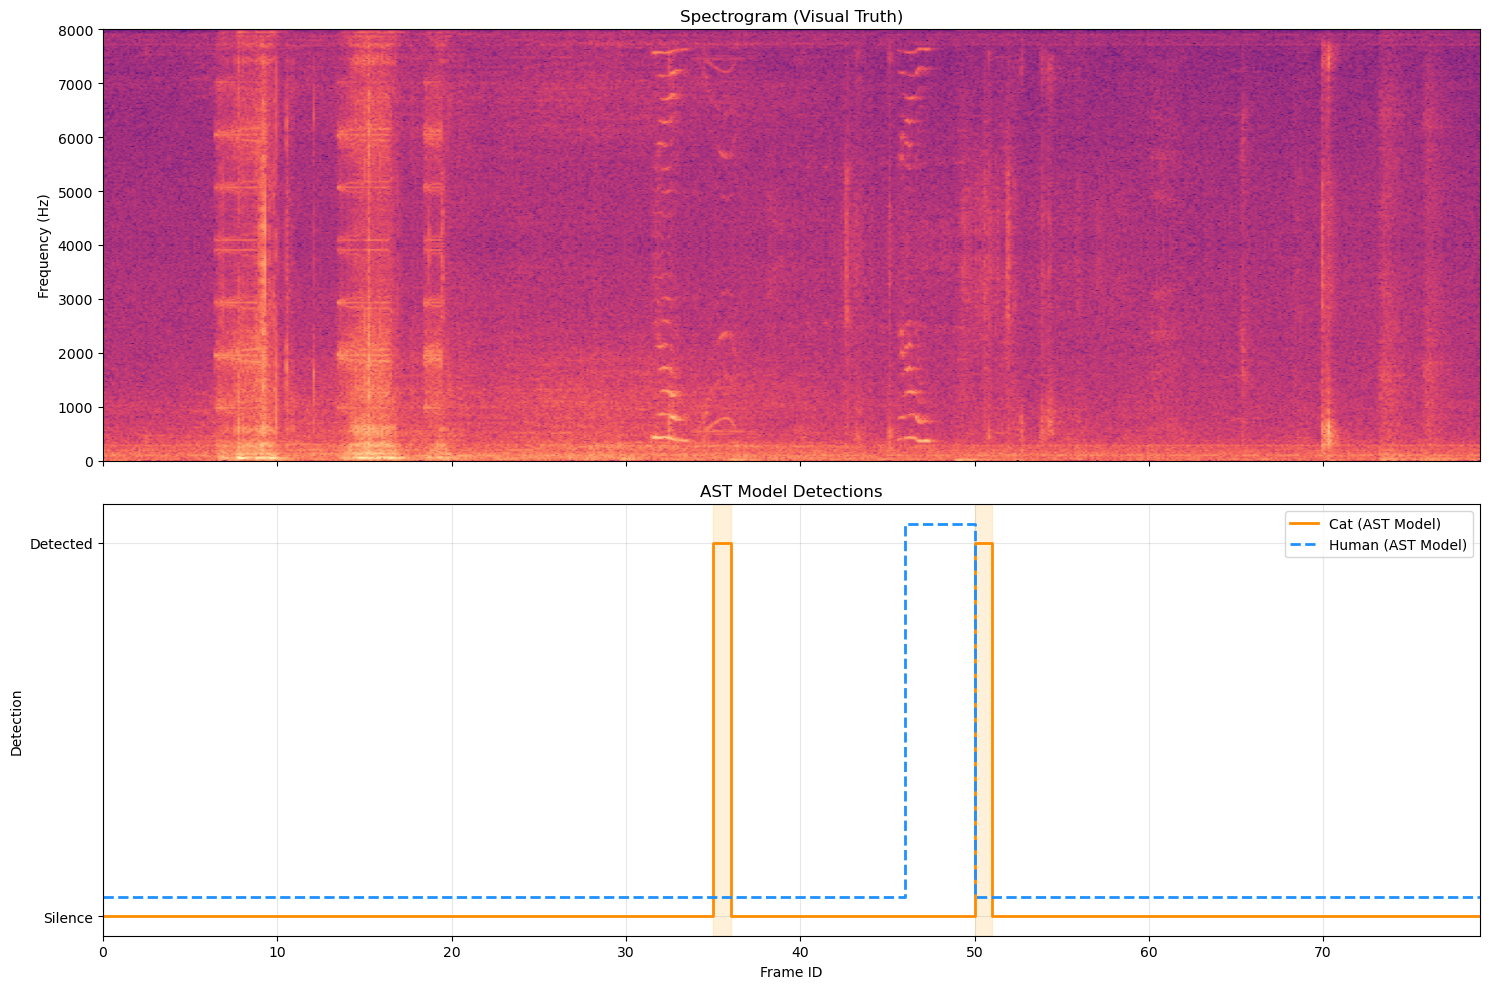

In [7]:
# --- CELL: SPECTROGRAM + DETECTION VISUALIZER ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import transformation_mart_pipeline as robot_code

# 1. Load Raw Data
print("Loading data...")
df_audio = pd.read_csv('stg_audio_data.csv')

# 2. Parse Audio Samples
print("Parsing audio samples...")
all_samples = []
frame_ids = []

def parse_samples(val):
    if isinstance(val, str):
        try: return ast.literal_eval(val)
        except: return []
    return val if isinstance(val, list) else []

for idx, row in df_audio.iterrows():
    s = parse_samples(row['audio_samples'])
    if s:
        all_samples.extend(s)
        frame_ids.append(row['frame_id'])

audio_stream = np.array(all_samples)

# 3. Run the Pipeline
print("Running detection pipeline...")
# This will now use the CPU and should NOT crash
t_audio = robot_code.transform_audio(df_audio)

# 4. PLOTTING
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# --- TOP PLOT: SPECTROGRAM ---
if len(audio_stream) > 0:
    Pxx, freqs, bins, im = ax1.specgram(
        audio_stream, 
        NFFT=1024, 
        Fs=16000,   
        noverlap=512, 
        cmap='magma'
    )
    # Align visual extent to frame IDs
    if frame_ids:
        im.set_extent([min(frame_ids), max(frame_ids), 0, 8000]) 
    
    ax1.set_ylabel("Frequency (Hz)")
    ax1.set_title("Spectrogram (Visual Truth)", fontsize=12)
    ax1.grid(False)

# --- BOTTOM PLOT: DETECTIONS ---
# Plot Cat Voice
ax2.plot(t_audio['frame_id'], t_audio['is_cat_voice'], 
         label='Cat (AST Model)', color='#FF8C00', linewidth=2, drawstyle='steps-post')

# Plot Human Voice
ax2.plot(t_audio['frame_id'], t_audio['is_human_voice'] + 0.05, 
         label='Human (AST Model)', color='#1E90FF', linestyle='--', linewidth=2, drawstyle='steps-post')

ax2.set_ylabel("Detection")
ax2.set_xlabel("Frame ID")
ax2.set_title("AST Model Detections", fontsize=12)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Silence', 'Detected'])
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Highlight detected regions
cat_indices = t_audio[t_audio['is_cat_voice'] == 1]['frame_id']
if not cat_indices.empty:
    for frame in cat_indices:
        ax2.axvspan(frame, frame + 1, color='orange', alpha=0.15)

plt.tight_layout()
plt.show()